# WindAI Competition Submission Notebook

In this notebook we will go though the whole pipeline for training and making prediction with the Local-Area model.
As the name suggest the model consists of two parts: a local model and an area model.
The main steps in the pipline are:
* Preparing the local dataset
* Tuning the local model
* Rolling monthly predictions with the local model
* Preparing the area dataset
* Training the area model
* Predicting with the area model

**Most of the code being run in this notebook has been made into a python package `wind` which can be found inside the `src` directory.
You can view this package to get an in depth look into the code.**

## Prepare Local Dataset
We first prepare the local dataset which is used to train the local model. 
Each row in the dataset corrsponds to a unique combination of `(time_ref, time, windpark, em)`.
We join together data from a number of different sources:
* Per park power production
* Weather forecasts
* Weather nowcasts
* Wind park information from NVE
* Wind park geolocation
* Site geography (elevation, terrain ruggedness)
* NordPool messages

In addition, some new features are created like estimated wind speed at hub heigh and seasonal features from day of year and hour of day.
The final dataset is saved to a parquet file `data/windpower_local_dataset.parquet` ready to be used for training.

In [ ]:
from wind.preprocess import prepare_local_data

prepare_local_data.main()

In [39]:
import polars as pl

pl.scan_parquet("data/windpower_local_dataset.parquet").select(prepare_local_data.LOCAL_FEATURES).describe()

statistic,lt,mean_hub_height,mean_rotor_diameter,unavailable_capacity,elevation,ruggedness,ELSPOT NO1,ELSPOT NO2,ELSPOT NO3,ELSPOT NO4,sin_hod,cos_hod,sin_doy,cos_doy,location_mean_ws,now_air_temperature_2m,now_air_pressure_at_sea_level,now_relative_humidity_2m,now_precipitation_amount,now_wind_speed_10m,now_wind_direction_10m,now_air_density,now_wind_alignment,now_wind_power_density,ws10m,wd10m,t2m,rh2m,mslp,g10m,wshh,adhh,phh,wind_power_density,wind_alignment,gust_factor
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.00365465e8,1.00365465e8,9.8675085e7,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,9.6984705e7,9.6984705e7,9.6984705e7,9.6984705e7,9.6984705e7,9.6984705e7,9.6984705e7,9.6984705e7,9.6984705e7,9.6984705e7,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8,1.00365465e8
"""null_count""",0.0,0.0,1.69038e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.38076e6,3.38076e6,3.38076e6,3.38076e6,3.38076e6,3.38076e6,3.38076e6,3.38076e6,3.38076e6,3.38076e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",30.961939,90.257684,111.876423,0.00124,293.004076,9.424743,0.059159,0.367698,0.375451,0.197692,-0.109217,0.002413,0.00848,0.031304,5.186022,279.882996,101032.804688,0.775099,0.141463,5.410737,196.976944,182.719559,5.237415,66070.867188,5.159636,188.987272,278.534169,0.816253,101025.305715,9.29176,7.020992,62.226864,9.8663e6,27095.59291,6.767513,2.005507
"""std""",18.197008,20.534021,26.06534,0.027361,192.854488,7.933811,null,null,null,null,0.685462,0.719866,0.708662,0.704802,1.147326,7.84964,1269.594116,0.157243,0.468339,3.226734,92.473221,3.150011,3.198712,129091.367188,3.366082,94.066418,7.004148,0.144111,1274.734655,5.331168,4.54733,1.181959,174790.697664,54727.554122,4.410618,1.580502
"""min""",0.0,46.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,2.396146,242.678024,95090.21875,0.183168,0.0,0.082625,0.003287,172.895096,0.025417,0.106056,0.000918,0.000003,246.63379,0.078253,93617.945,0.20077,0.001197,57.23073,8.9852e6,5.3204e-8,0.0004,1.052264
"""25%""",15.0,80.0,93.0,0.0,188.072501,1.317711,null,null,null,null,-0.707107,-0.707107,-0.697459,-0.676388,4.525589,274.276337,100227.21875,0.666965,0.0,2.980468,129.674698,180.425156,2.798435,4832.808105,2.6010427,119.83328,273.81363,0.7221888,100222.84,5.2060723,3.563303,61.410939,9.7497e6,1409.08901,3.417955,1.597115
"""50%""",31.0,87.0,117.0,0.0,289.930207,8.983179,null,null,null,null,-0.258819,-1.8370e-16,0.010752,0.079933,5.212686,279.554077,101115.09375,0.789235,0.000067,4.743813,196.200989,182.481735,4.587748,19490.179688,4.4203467,183.88568,278.3672,0.8413148,101114.45,8.291565,6.033511,62.204727,9.8731e6,6826.853338,5.821443,1.822605
"""75%""",47.0,94.0,130.0,0.0,413.001619,14.17059,null,null,null,null,0.5,0.707107,0.729632,0.722597,5.723795,285.760101,101904.570312,0.907324,0.034137,7.207489,274.935516,184.815414,7.042435,68327.117188,7.0028696,267.2443,283.6587,0.9370654,101901.77,12.383575,9.521645,63.021041,9.9886e6,26825.45761,9.196124,2.145455
"""max""",64.0,145.0,150.0,1.0,746.520027,29.555279,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.032251,306.619873,105009.953125,1.000008,10.447779,25.897648,359.998993,198.084579,25.500566,1.5235e6,36.23216,360.0,306.90314,1.0000076,105242.5,58.075493,49.524219,67.631093,1.0471e7,516430.470997,44.767356,2581.442812


## Make Local Predictions
We have local power production data up to and including 2024.
Since we will be training a second model on the outputs of the first one, we have to make sure that we do not leak future information.
To avoid information leakage, all predictions can only be made using data preceding the prediction time.
For each month in the period from 2020 to 2024, we train a model on the preceding data and make a prediction for the following month.   
We make a separate prediction for each ensemble member in the weather forecast. We will later use the ensemble spread to estimate uncertainty in the area model.

In [ ]:
from wind.model import pred_local_windpower

pred_local_windpower.main()

## Prepare Area Dataset
Here we prepare the data for the area model. This is a much smaller dataset than the local dataset, both due to the reduced granularity and because we use fewer data sourced. The fearues are constructed from ensemble model output statisics (EMOS) from the local model, like mean, std and range. 
We also use lagged area power production as features.

In [38]:
from wind.preprocess import prepare_area_data

prepare_area_data.main()

Retrieved: 2000 ---- Progress: 2000/8519
Retrieved: 2000 ---- Progress: 4000/8519
Retrieved: 2000 ---- Progress: 6000/8519
Retrieved: 2000 ---- Progress: 8000/8519
Retrieved: 519 ---- Progress: 8519/8519


## Make Area Predictions
For the area model we train a Bayesian linear model with logit-normal likelihood for each bidding area. 
We construct two design matrices corresponding to the $\mu$ and $\sigma$ parameters of a logit-normal distribution.
The model is thus given by the equation:

$\text{logit}(Y) \sim \mathcal{N}(\mu, \sigma^2)$ where $\mu = X_{\mu} \beta$ and $ \sigma = \exp (X_{\sigma} \gamma)$

We set the priors for the $\beta$ paramers to $\mathcal{N}(0, 2)$ and for $\gamma$ we use to $\mathcal{N}(0, 0.2)$

In [ ]:
from wind.model.pred_area_bayesian import BayesianAreaModel, get_emos_features
from wind.evaluate.evaluate_models import crps, get_eval_set
import polars as pl
import numpy as np
from datetime import timedelta

bidding_area = "ELSPOT NO3"

y_true = get_eval_set().filter(pl.col("bidding_area") == bidding_area)
val_cutoff = y_true.select(pl.col("time_ref").min()).collect().item()
data = pl.scan_parquet("data/windpower_area_dataset.parquet").filter(
    pl.col("time").dt.date() == (pl.col("time_ref") + timedelta(days=2)).dt.date(),
    pl.col("bidding_area") == bidding_area
)

df_train = (
    data.filter(
        pl.col("time_ref") < val_cutoff,
        pl.col("time_ref") >= val_cutoff - timedelta(days=365),
        pl.col("relative_power").is_not_null(),
    )
    .sort("bidding_area", "time_ref", "time")
    .select(
        pl.col("*").fill_null(strategy="forward").over("bidding_area"),
    )
)

df_val = (
    y_true.join(data, on=["bidding_area", "time_ref", "time"], how="left")
    .sort("bidding_area", "time_ref", "time")
    .select(
        pl.col("*").fill_null(strategy="forward").over("bidding_area"),
    )
)

preds = []
X_mu_train, X_sigma_train, y_train, scaling_factor_train = get_emos_features(
    df_train
)
X_mu_val, X_sigma_val, y_val, scaling_factor_val = get_emos_features(
    df_val
)

area_model = BayesianAreaModel()
area_model.fit(X_mu_train, X_sigma_train, y_train, tune=1000, draws=1000)
samples = area_model.predict(X_mu_val, X_sigma_val) * np.expand_dims(
    scaling_factor_val, 1
)

lower90, pred_median, upper90 = np.quantile(samples, (0.05, 0.5, 0.95), axis=1)

pred_mean = np.mean(samples, axis=1)
y_true_values = df_val.select("y_true").collect().to_numpy()[:, 0]
rmse_score = np.sqrt(np.mean((y_true_values - pred_mean) ** 2))
crps_score = crps(y_true_values, samples.T)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.12,63
,2000,0,0.11,63
,2000,0,0.12,63
,2000,0,0.11,255


Sampling: [y]


Output()

In [40]:
lower90, pred_median, upper90 = np.quantile(samples, (0.05, 0.5, 0.95), axis=1)


In [5]:
print("RMSE:", rmse_score)
print("CPRS:", crps_score)

RMSE: 319.8256991672462
CPRS: 167.52800477066714


In [42]:
df_plot = df_val.select("y_true", "time").collect()

df_plot.with_columns(lower90=lower90, pred_median=pred_median, upper90=upper90).with_columns(
    under90=pl.col("y_true") < pl.col("lower90"),
    over90=pl.col("y_true") > pl.col("upper90"),
    over_median=pl.col("y_true") > pl.col("pred_median"),
).select(
    pl.col("under90").mean(),
    (~pl.col("under90") & ~pl.col("over90")).mean().alias("in90"),
    pl.col("over90").mean(),
    pl.col("over_median").mean(),
)

under90,in90,over90,over_median
f64,f64,f64,f64
0.125403,0.870447,0.004149,0.39834


We the table above we can see that the 90% confidence interval covered 87% of actual values in the validation set, which is not too far off.
However we see that the model overall underestimates production, with very few values falling over the confidence interval and only ~40% of actual values being over the prediction median. We might want to look into another likelihood which can better model the actual distribution.   

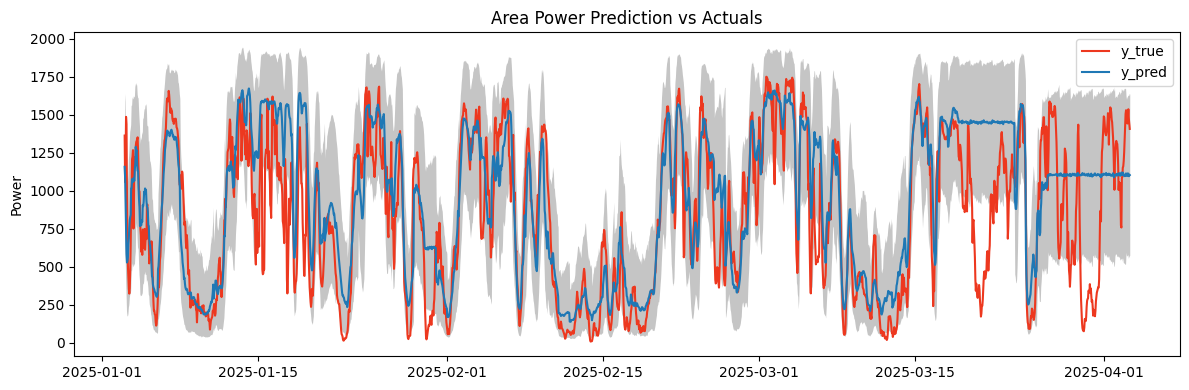

In [31]:
import matplotlib.pyplot as plt

df_plot = df_val.select("y_true", "time").collect()

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df_plot["time"], df_plot["y_true"], color=(0.93, 0.22, 0.12), label="y_true")
ax.plot(df_plot["time"], pred_mean, color=(0.12, 0.47, 0.71), label="y_pred")
ax.fill_between(df_plot["time"], lower90, upper90, lw=0, color=(0.25, 0.25, 0.25, 0.3))
ax.set_ylabel("Power")
ax.set_title("Area Power Prediction vs Actuals")
plt.legend()
plt.tight_layout()
plt.show()

We can see that the model generally predicts close to the actual values. In some periods we see sharp drops in production which the model is not able to predict. We can also see periods of missing data where the model uses the last seen observation. We might want to add a "time since last non-missing observation" to allow the model to increase uncertainty during these periods.